# Bootstrapping Method for Correlation Hypothesis Test

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)

from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")  

import scipy.stats as st 

## The data

Let's use the generated data from the previous notebook.

In [2]:
data = pd.read_csv('corrExamples.csv')
print(data.shape)
data.head()

(30, 7)


,x,y_spc,y_snc,y_wpc,y_wnc,y_nc,y_nc2
0,0.864861,5.966722,33.891055,20.747607,33.228954,60.257958,5.417415
1,-0.715509,2.660711,34.377933,22.650736,44.177148,61.157429,4.245928
2,0.978287,5.498195,33.150306,17.931824,27.620634,42.349386,4.987811
3,-2.018096,0.917615,35.761044,15.819973,38.082087,76.338343,8.017468
4,2.775647,7.935774,31.274222,31.112353,42.790156,38.697988,11.476520


## Computing the correlation

Let's use the NumPy function `corrcoef` for calculating the correlation.

In [3]:
np.corrcoef(data.x, data.y_spc)

array([[1.        , 0.98296946],
       [0.98296946, 1.        ]])

The result is a symmetric matrix. In this case, we are interested in the non-diagonal values.

In [4]:
np.corrcoef(data.x, data.y_spc)[0][1]

0.9829694635784151

In [5]:
# The correlation matrix is symmetric.
np.corrcoef(data.x, data.y_spc)[1][0]


0.9829694635784151

In [6]:
# The statistic
stat_r = np.corrcoef(data.x, data.y_spc)[0][1]
print('stat = %.3f' % stat_r)

stat = 0.983


In [7]:
# The statistic using scipy
stat, p = st.pearsonr(data.x, data.y_spc)
print('stat = %.3f \t p = %.4f' % (stat, p))

stat = 0.983 	 p = 0.0000


## Computing the sample distribution

In [8]:
# Computing the sample distribution for correlation
def get_boot_sample_distribution_corr(x, y, num_samples=10000):
    '''
    It computes the sample distribution for correlation using bootstrap.
    '''    
    bootstrap_corrs = np.array([np.corrcoef(
                        np.random.choice(x, size=len(x), replace=True), 
                        np.random.choice(y, size=len(y), replace=True)
                    )[0][1] for _ in range(num_samples)])
    return bootstrap_corrs

In [9]:
sample_distribution_r = get_boot_sample_distribution_corr(data.x, data.y_spc)

Let's plot the sample distribution.

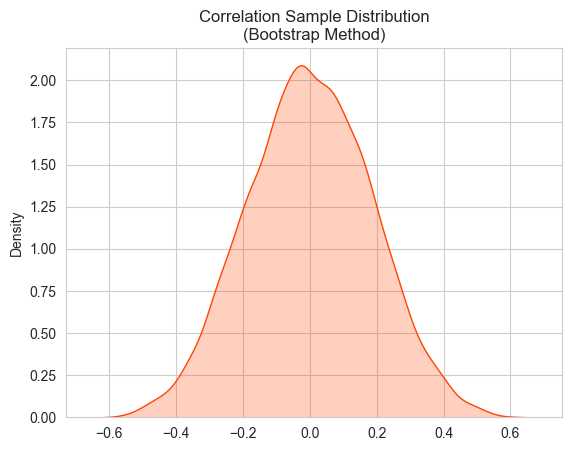

In [10]:
sns.kdeplot(sample_distribution_r, fill=True, color='orangered').set(
            title='Correlation Sample Distribution\n(Bootstrap Method)');

## The bootstrap hypothesis test for correlation

Let's use the `get_p_value` function we already know.

In [11]:
def get_p_value(sample_distribution, obs_value, alternative='two-sided'):
    '''
    It returns the p-value.
    sample_distribution: the sample distribution
    obs_value:           observed value     
    alternative:         'two-sided', 'smaller', or 'larger'    
    '''
    ecdf = ECDF(sample_distribution) 
    if alternative=='two-sided':
        p_val = 2 * min(ecdf(obs_value), 1-ecdf(obs_value))
    elif alternative=='smaller':
        p_val = ecdf(obs_value)
    else:
        p_val = 1-ecdf(obs_value)
    return(p_val)

Let's create the function: `graph_hyp_test_corr` to calculate the correlation coefficient's bootstrap hypothesis test.

In [12]:
def graph_hyp_test_corr(sample_value, sample_distribution, alpha=0.05):
    '''
    It calculates the resampling hypothesis test for correlation.
    sample_value:        statistic calculated from the sample
    sample_distribution: sample distribution calculated from the sample
    alpha:               significance level    
    '''
    print('--- Correlation Hypothesis Test ---')
    print('    Ho: r == 0')
    print('    Ha: r != 0')    
    # plotting the sample distribution
    sns.kdeplot(x=sample_distribution, color='lightskyblue', fill=True)
    plt.title('Sampling Distribution for Correlation')
    # plotting the statistic
    plt.axvline(x=sample_value, ymin=0, ymax= 0.03, color='black', linewidth=6)
    # calculating the p-value
    p_val = get_p_value(sample_distribution, sample_value)
    # plotting the critical regions
    cv1 = np.percentile(sample_distribution, (alpha/2)*100)         # left critical value  
    cv2 = np.percentile(sample_distribution, 100-(alpha/2)*100)     # right critical value  
    plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    print('    r = %.4f    p-value = %.4f' %(sample_value, p_val))

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.9830    p-value = 0.0000


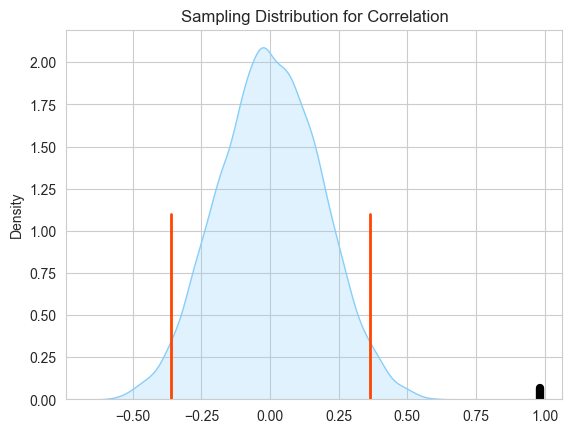

In [13]:
# Generated data with strong positive correlation
graph_hyp_test_corr(stat_r, sample_distribution_r)

p-value < 0.01 We are rejecting the null hypothesis!

There is a strong correlation between the two variables: `data.x` and `data.y_spc.` Remember, we are using the same set of data previously generated.

## Computing several correlation hypothesis tests

Let's create a function for computing the correlation between two variables.

In [14]:
def corr_bootstrap(x, y, num_samples=10000):
    '''
    It calculates the bootstrapping hypothesis test for correlation.
    '''
    # computing the correlation (statistic)
    stat_r = np.corrcoef(x, y)[0][1]    
    # computing the sample distribution for correlation
    sample_distribution_r = get_boot_sample_distribution_corr(x, y, num_samples=num_samples)    
    # plotting the hypothesis test
    graph_hyp_test_corr(stat_r, sample_distribution_r)

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = -0.9496    p-value = 0.0000


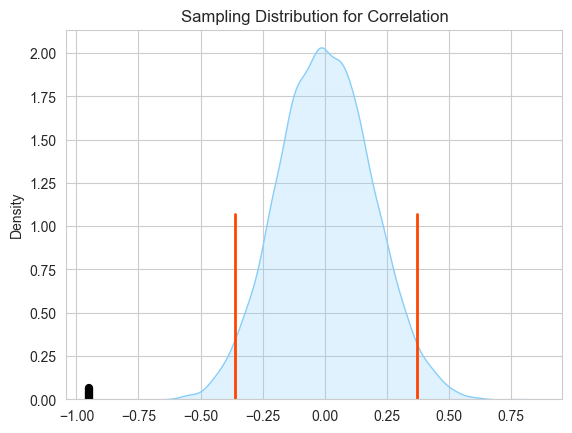

In [15]:
# Generated data with strong negative correlation
corr_bootstrap(data.x, data.y_snc)

The correlation value is -0.9496, and it is highly significant.

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.3758    p-value = 0.0396


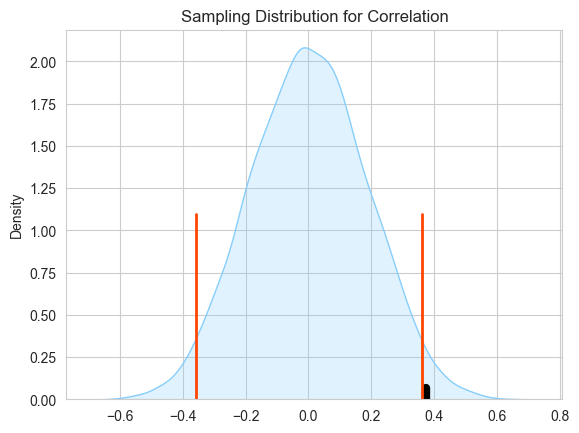

In [16]:
# Generated data with weak positive correlation
corr_bootstrap(data.x, data.y_wpc)

The correlation value is 0.3758. Notice the p-value is 0.0420. There is a weak correlation and it is positive.

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = -0.3743    p-value = 0.0392


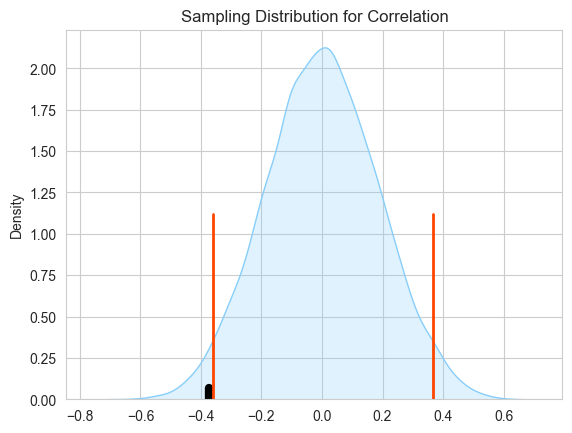

In [17]:
# Generated data with weak negative correlation
corr_bootstrap(data.x, data.y_wnc)

Here we have a similar situation with a weak negative correlation.

Now, we will show two examples of no correlation.

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = -0.2328    p-value = 0.2140


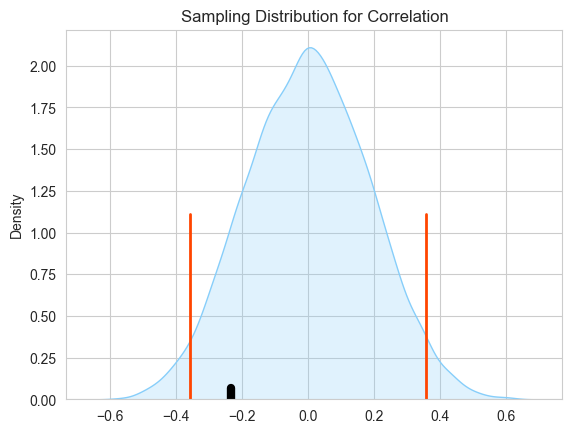

In [18]:
# Generated data with no correlation
corr_bootstrap(data.x, data.y_nc)

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.1414    p-value = 0.4520


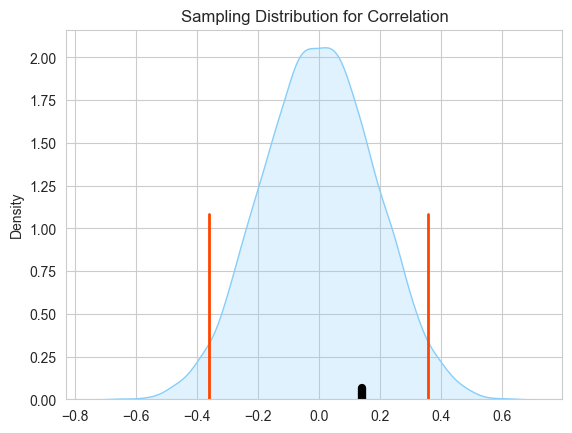

In [19]:
# Generated data with no correlation
corr_bootstrap(data.x, data.y_nc2)

## Real-world examples

Let's analyze some real-world examples.

### Student Performance Dataset

In [20]:
st = pd.read_csv('student-mat.csv', sep=';')
print(st.shape)
st.head()

(395, 33)


,school,sex,age,address,famsize,...,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,...,3,6,5,6,6
1,GP,F,17,U,GT3,...,3,4,5,5,6
2,GP,F,15,U,LE3,...,3,10,7,8,10
3,GP,F,15,U,GT3,...,5,2,15,14,15
4,GP,F,16,U,GT3,...,5,4,6,10,10


Let's work with the variables:

- **G1**: first period grade (numeric: from 0 to 20)
- **G2**: second period grade (numeric: from 0 to 20)
- **G3**: final grade (numeric: from 0 to 20, output target)

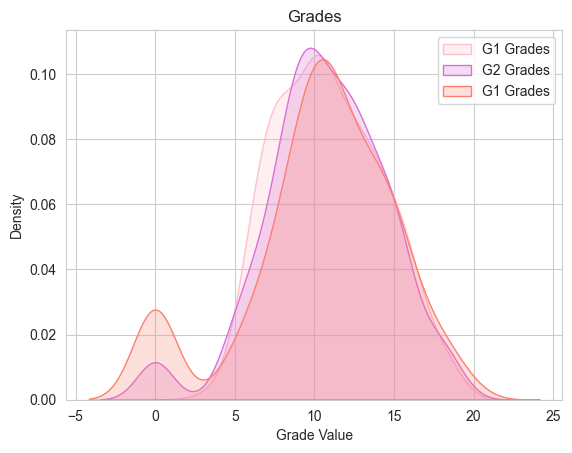

In [21]:
# kde plots for grades
sns.kdeplot(st.G1, fill=True, color='pink',   label ='G1 Grades')
sns.kdeplot(st.G2, fill=True, color='orchid', label ='G2 Grades')
sns.kdeplot(st.G3, fill=True, color='salmon', label ='G1 Grades').set(title='Grades')
plt.xlabel('Grade Value')
plt.legend();

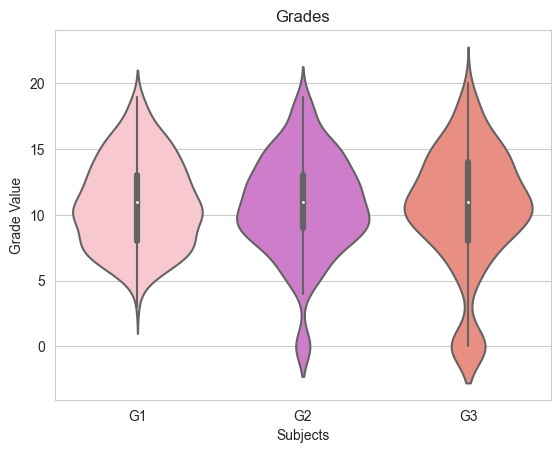

In [22]:
# Violine plots for grades
# Set custom colors
custom_palette = {'G1': 'pink', 'G2': 'orchid', 'G3': 'salmon'}

# Create the violin plots with custom colors
sns.violinplot(data=st[['G1', 'G2', 'G3']], palette=custom_palette)

# Set title and labels
plt.title('Grades')
plt.xlabel('Subjects')
plt.ylabel('Grade Value');

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.8521    p-value = 0.0000


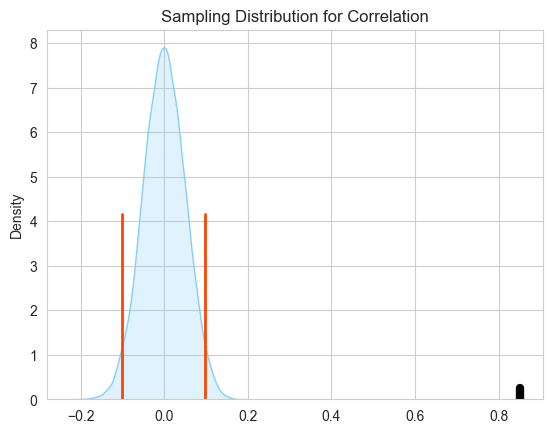

In [23]:
# Bootstrap correlation between G1 and G2
corr_bootstrap(st.G1, st.G2)

There is a positive correlation between the grades G1 and G2. It is highly significant!

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.9049    p-value = 0.0000


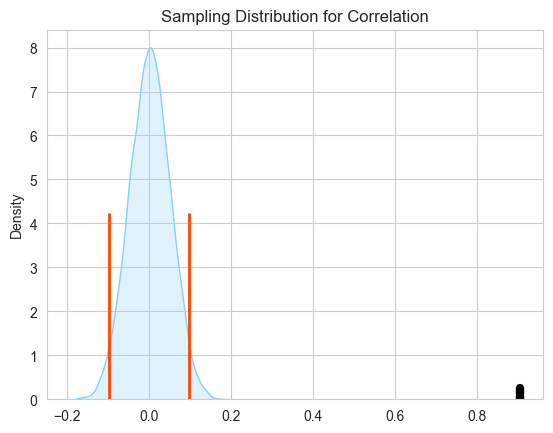

In [24]:
# Bootstrap correlation between G2 and G3
corr_bootstrap(st.G2, st.G3)

There is also a positive correlation between the grades G2 and G3. It is highly significant!

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.8015    p-value = 0.0000


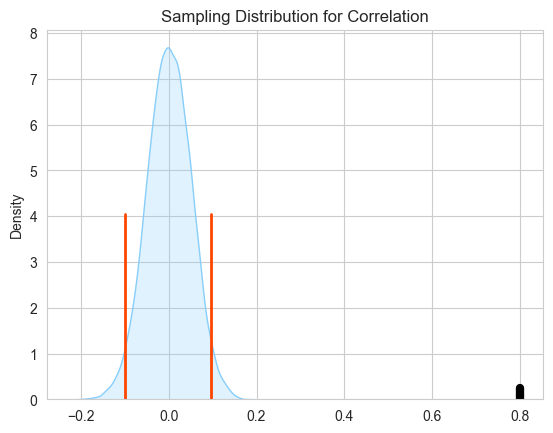

In [25]:
# Bootstrap correlation between G1 and G3
corr_bootstrap(st.G1, st.G3)

There is a positive significant correlation between all the pairs. The following plot corroborates it.

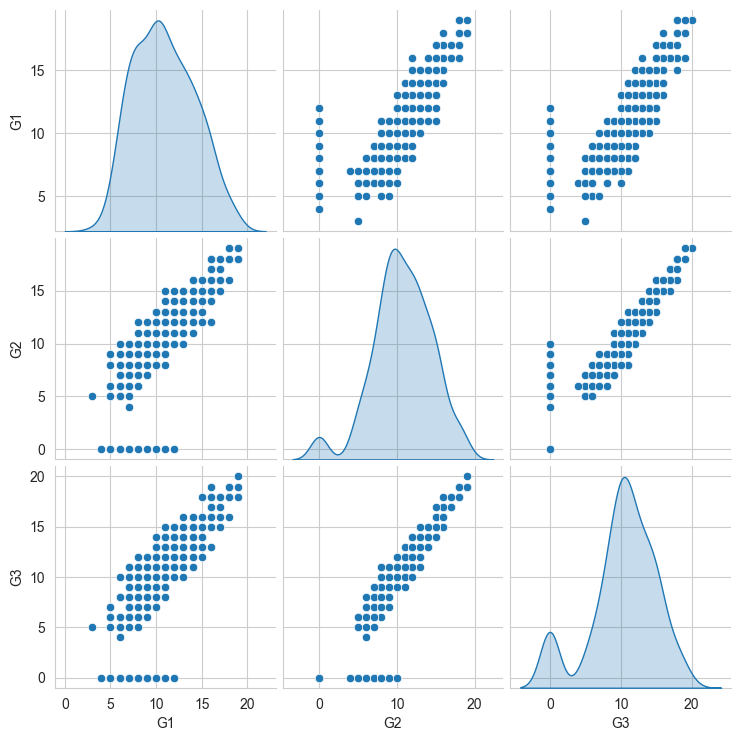

In [26]:
sns.pairplot(st[['G1', 'G2', 'G3']], diag_kind='kde');

### IBM HR Analytics Employee Attrition & Performance Dataset

In [27]:
hr = pd.read_csv('HR-Employee-Attrition.csv')
print(hr.shape)
hr.head()

(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,...,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,...,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,...,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,...,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,...,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,...,3,2,2,2,2


This dataset has several variables, but we will be working with three of them:
- **YearsAtCompany**: years working at company
- **MonthlyIncome**: monthly income
- **DistanceFromHome**: distance from home

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.5143    p-value = 0.0000


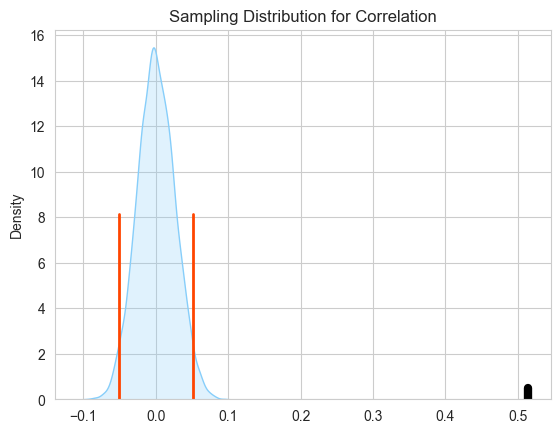

In [28]:
corr_bootstrap(hr.YearsAtCompany, hr.MonthlyIncome)

The years of work in the company are directly related to the worker's monthly salary.

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.0095    p-value = 0.7082


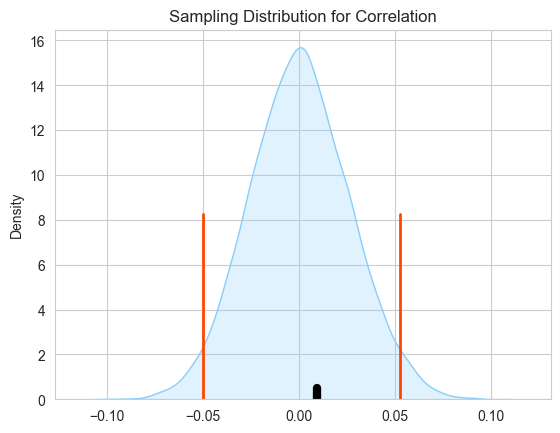

In [29]:
corr_bootstrap(hr.YearsAtCompany, hr.DistanceFromHome)

The years of work in the company do not depend on the distance the workers live.

## References

- VanderPlas, J. (2017) Python Data Science Handbook: Essential Tools for Working with Data. USA: O’Reilly Media, Inc. chapter 4.